### Save contextualized vectors 

In [ ]:
import json, os
from proteinbert import load_pretrained_model
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs
import numpy as np

ALL_AAS = 'ACDEFGHIKLMNPQRSTUVWXY'

seq_len = 3072
pretrained_model_generator, input_encoder = load_pretrained_model()
model = get_model_with_hidden_layers_as_outputs(pretrained_model_generator.create_model(seq_len))

seq_path = "C:\\Users\\efeka\\Documents\\GitHub\\549-term-project\\alignment\\all_sequences.json"

with open(seq_path, 'r') as f:
    sequences = json.load(f)

vector_list = []
local_rep_aa_list = []
index = 0
for sequence in sequences:
    ref = sequence.split('-')[0]
    msa = sequence.split('-')[1]
    sequence_name = sequence.split('-')[2]
    #if ref == "RV912":
    #print(sequence)
    #index +=1
    #if index == 100:
    #    break
    seq_t = sequences[sequence]

    encoded_x = input_encoder.encode_X([seq_t], seq_len)
    local_representations, _ = model.predict(encoded_x, batch_size = 1, verbose = 0)

    # SPECIAL TOKENS: 22: UNK, 23: BOS, 24: EOS, 25: PAD
    #mask_to_exclude_special_tokens =  encoded_x[0][0] < 23 # exclude 23: BOS, 24: EOS, 25: PAD
    #local_rep = local_representations[0][mask_to_exclude_special_tokens]

    mask_to_include_aa =  encoded_x[0][0] < 23 # exclude 23: BOS, 24: EOS, 25: PAD 
    local_rep = local_representations[0][mask_to_include_aa]
    
    for vector in local_rep:
        # Convert the 1D array to a Python list and append to vector_list
        vector_list.append(vector) # [-154:-26]
    
    for aa_index in encoded_x[0][0][mask_to_include_aa]:
        local_rep_aa_list.append(aa_index)
        
#np.savetxt(f"output_representations/{ref}/{msa}/{sequence_name}.txt", local_rep)
np.savetxt(f"vector_list_full.txt", vector_list)
np.savetxt(f"local_rep_full_aa_list.txt", local_rep_aa_list)


### Clustering

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib import cm
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE

In [17]:
ALL_AAS = 'ACDEFGHIKLMNPQRSTUVWXY'
vector_list = np.loadtxt("vector_list.txt")
local_rep_aa_list = np.loadtxt("local_rep_aa_list.txt")

In [18]:
vector_list = np.array(vector_list)
local_rep_aa_list = np.array(local_rep_aa_list,dtype=int)
print(vector_list.shape, local_rep_aa_list.shape)
aa_dict = {}

(764769, 128) (764769,)


In [19]:
np.unique(local_rep_aa_list)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       18, 19, 20, 21])

#### PCA plot

In [20]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(vector_list)

764769


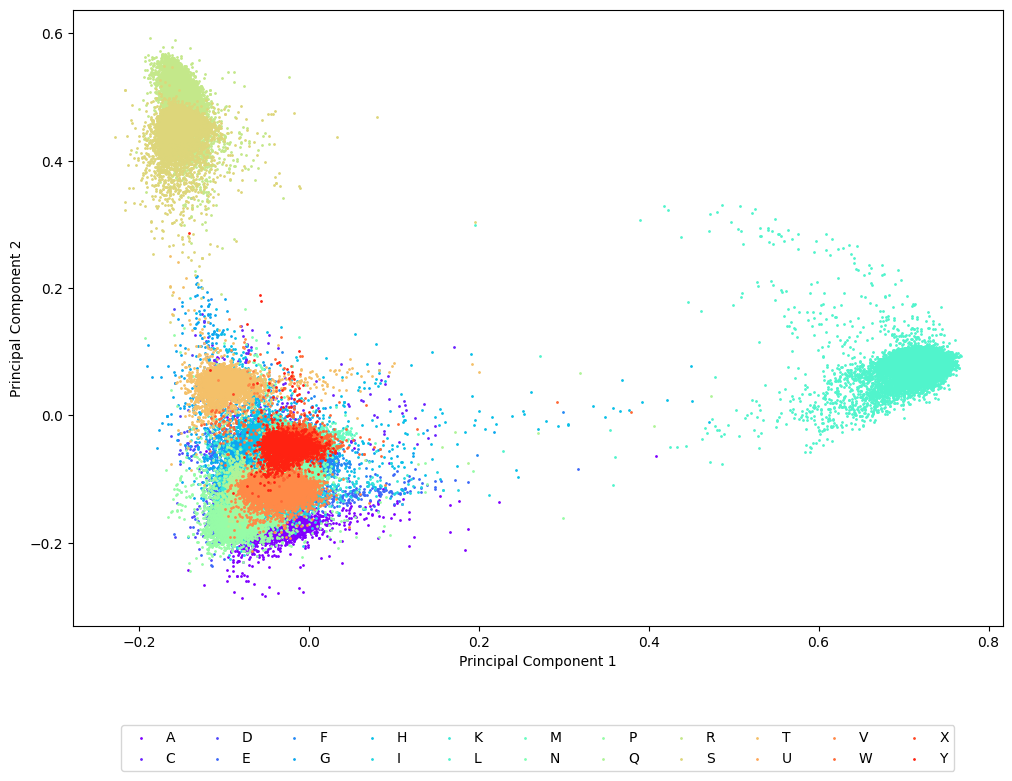

In [44]:
plt.figure(figsize=(12, 8))
markersize = 1
num_colors = 22
colors = [cm.rainbow(i/num_colors) for i in range(num_colors)]
index = 0
for i in range(len(ALL_AAS)):
    aa_indices = np.where(local_rep_aa_list == i )
    plt.scatter(principal_components[aa_indices[0], 0], principal_components[aa_indices[0], 1], color = colors[i], s=markersize,label = ALL_AAS[i] )
    index += len(aa_indices[0])
print(index)
#plt.title('PCA Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=11)
plt.show()

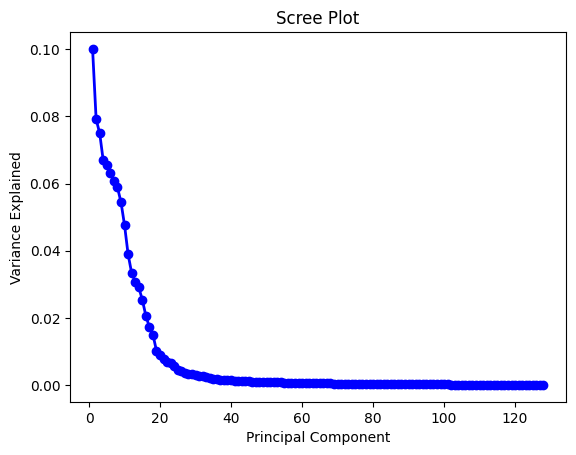

In [15]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

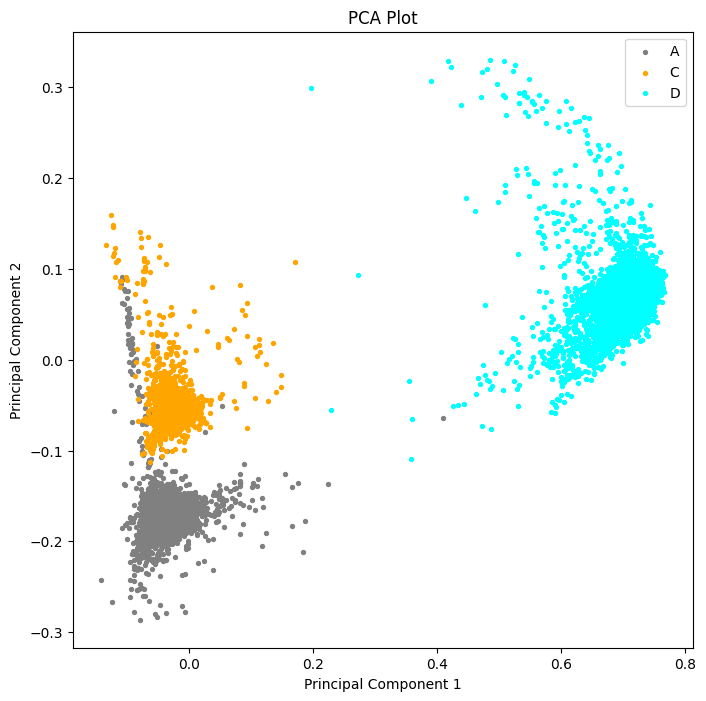

In [39]:
plt.figure(figsize=(8, 8))
markersize = 8
A_indices = np.where(local_rep_aa_list ==0)
plt.scatter(principal_components[A_indices, 0], principal_components[A_indices, 1], c = "gray", s=markersize,label = "A" )
C_indices = np.where(local_rep_aa_list ==1)
plt.scatter(principal_components[C_indices, 0], principal_components[C_indices, 1], c = "orange", s=markersize ,label = "C" )
D_indices = np.where(local_rep_aa_list == 2)
plt.scatter(principal_components[D_indices, 0], principal_components[D_indices, 1], c = "cyan", s=markersize,label = "D" )
#legend_elements = []
# Get the list of colors

#for i in range(num_colors):
#    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=ALL_AAS[i],markerfacecolor=colors[i], markersize=8))
plt.title('PCA Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# produce a legend with the unique colors from the scatter
plt.legend()
plt.show()

#### Silhouette Analysis

In [75]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(vector_list)


AT K=15
For k=15, silhouette score: 0.5820115918538837
AT K=16
For k=16, silhouette score: 0.6104947586733924
AT K=17
For k=17, silhouette score: 0.6286749002312313
AT K=18
For k=18, silhouette score: 0.6414424397367565
AT K=19
For k=19, silhouette score: 0.6495497055100965
AT K=20
For k=20, silhouette score: 0.652810520560608
AT K=21
For k=21, silhouette score: 0.6416903464066962
AT K=22
For k=22, silhouette score: 0.6361281431012965
AT K=23
For k=23, silhouette score: 0.6156146331041777
AT K=24
For k=24, silhouette score: 0.6310211974275021
AT K=25
For k=25, silhouette score: 0.6064962135369403
AT K=26
For k=26, silhouette score: 0.5737486335907815
AT K=27
For k=27, silhouette score: 0.5572681203418367
AT K=28
For k=28, silhouette score: 0.5618443526035457
AT K=29
For k=29, silhouette score: 0.5971617713714493
AT K=30
For k=30, silhouette score: 0.5465864727868803
AT K=31
For k=31, silhouette score: 0.5320163158531345
AT K=32
For k=32, silhouette score: 0.5507794587078522
AT K=33
For

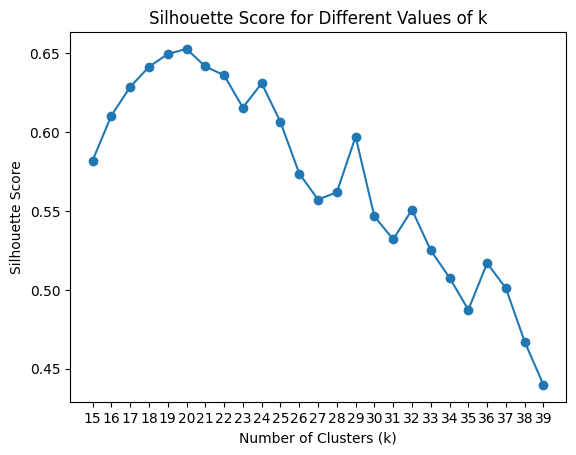

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random 

# Generate random indices to sample
random_indices = np.random.choice(vector_list.shape[0], 35000, replace=False)

# Use the random indices to select rows from the array
sampled_data = vector_list[random_indices]
# Define a range of k values
k_values = range(15,40)

# Initialize lists to store silhouette scores for each k
silhouette_scores = []

# Iterate over each k value
for k in k_values:
    # Fit KMeans model
    print(f"AT K={k}")
    kmeans = KMeans(n_clusters=k, random_state=42,verbose=0,n_init=10)
    cluster_labels = kmeans.fit_predict(sampled_data)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(sampled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # Print silhouette score for each k
    print(f"For k={k}, silhouette score: {silhouette_avg}")

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.xticks(k_values)
plt.ylabel('Silhouette Score')
plt.show()

In [10]:
np.save('sampled_data.npy',sampled_data)
np.save('random_indices.npy',random_indices)

In [11]:
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42,perplexity=40)
tsne_result = tsne.fit_transform(sampled_data)

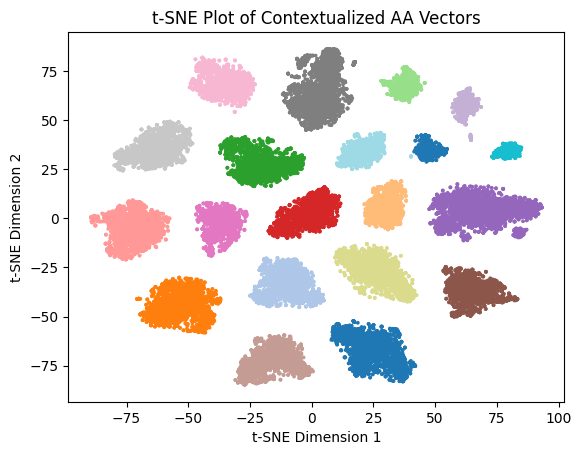

In [13]:
# Plot the t-SNE results
plt.scatter(tsne_result[:, 0], tsne_result[:, 1],c=local_rep_aa_list[random_indices], cmap="tab20", s=3)
plt.title('t-SNE Plot of Contextualized AA Vectors')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()
